# MCMC for Linear regression with normal distribution

In [43]:
# import libraries
import jax
import jax.numpy as jnp
try:
  import distrax
except:
  %pip install -qq distrax
  import distrax
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pickle
import logging
from rmh import rmh_inference_loop,plot_rmh
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
key = jax.random.PRNGKey(5)

Lets generate samples now.

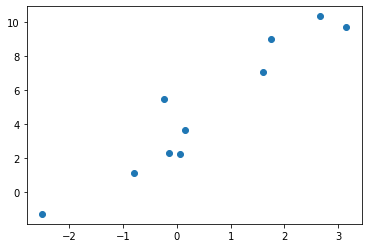

In [34]:
with open("../data/linear_regression",'rb') as f:
    data = pickle.load(f)
x = jnp.array(data['data']['x'])
def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)
m = x.shape[0]
x_trans = identity_trans(x)
y = jnp.array(data['data']['y'])
prior_mean = jnp.array(data['prior']['mean'])
prior_var = jnp.array(data['prior']['var'])
noise_var = data['noise_variance']
plt.scatter(x,y)

In [35]:
n = x_trans.shape[1]
alpha = 10
beta = 15
prior_normal = tfd.MultivariateNormalFullCovariance(
    loc = prior_mean,covariance_matrix= prior_var
)

print(prior_normal.prob((prior_mean)))

0.015915498


In [36]:
y = y.reshape(m,)
def log_postfn(theta):
  # from the above equation
  # log_prior = -(x/lamda)**k+ (k-1)*(jnp.log(x)-jnp.log(lamda)) +jnp.log(k/lamda)
  theta = theta['theta']
  log_prior = prior_normal.log_prob(theta)
  # log_likelihood
  mean = (x_trans@theta.reshape(n,1)).reshape(m,)
  likelihood_normal = tfd.MultivariateNormalFullCovariance(mean,jnp.identity(m))
  log_like = jnp.array(likelihood_normal.log_prob(y))
  return (log_like+log_prior)

RMH here stands for Random walk Metropolis Hastings.
We will use the blackjax implementation of it.

Things we have to do using jax


*   rmh takes the log of posterior pdf and sigma is the walk length parameter. So give them.
*   Then define the initial state of the rmh. This is done by just giving the initial value of whatever we are trying to estimate.




In [49]:
initial = {"theta":(prior_mean)}

Lets generate samples from posterior distribution now.

lets now see how it is varying. As we can see from the below figure, the parameter is changing a lot durin the first 300 iterations and then having a stationary distribution. So we eliminate the first 300 samples and then just take a target distribution as the emperical distribution of the samples.

In [50]:
states = rmh_inference_loop(log_postfn,jnp.identity(n) * 0.7,initial,10000)

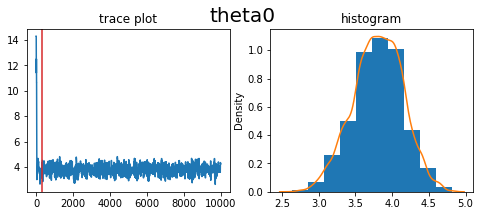

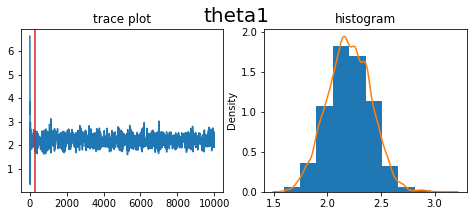

In [53]:
burnin = 300
plot_rmh(states,burnin,contains_arrays=True)

Now lets see how well the samples are fitting our initial data.

I will just compare with the actual pdf.

<h1> So I am happy :)</h1>